In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
#tutorial link: https://www.kaggle.com/kanncaa1/recurren

In [3]:
import time
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    return str(time.time() - startTime_for_tictoc) 

tic()
time.sleep(1)
print(toc())

1.0051188468933105


In [4]:
#classes small large, left right, negative positive
basePatterns=[
    [ 1.0, 1.0, 0.0, 0.0],
    [ 0.0, 0.0, 1.0, 1.0],
    [ 1.0, 1.0, 1.0, 0.0],
    [ 0.0, 1.0, 1.0, 1.0],
    [-1.0,-1.0, 0.0, 0.0],
    [ 0.0, 0.0,-1.0,-1.0],
    [-1.0,-1.0,-1.0, 0.0],
    [ 0.0,-1.0,-1.0,-1.0]
 ]
altBasePatters=[
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1]
]
S=[]
T=[]
for pattern in basePatterns:
    for i in range(3):
        B=list(numpy.zeros((4,4)))
        B[i]=pattern
        B[i+1]=pattern
        A=list(numpy.zeros(8))
        A[basePatterns.index(pattern)]=1.0
        T.append(A)
        S.append(B)
signals=torch.tensor(S).float()
labels=torch.tensor(T)*1.0
#print(signals,labels)
altLabels=[]
for i in range(8):
    for j in range(3):
        altLabels.append(altBasePatters[i])
altLabels=torch.tensor(altLabels)*1.0

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_19457/2603037658.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484780698/work/torch/csrc/utils/tensor_new.cpp:204.)
  signals=torch.tensor(S).float()


In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,startZero=False,dropout=0.0):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        if dropout==0.0:
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                          nonlinearity='tanh')   
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
              nonlinearity='tanh',dropout=dropout)   

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        if startZero:
            self.rnn.weight_ih_l0.data.fill_(0.0)
            self.rnn.weight_hh_l0.data.fill_(0.0)
            self.rnn.bias_ih_l0.data.fill_(0.0)
            self.rnn.bias_hh_l0.data.fill_(0.0)
            self.fc.weight.data.fill_(0.0)
            self.fc.bias.data.fill_(0.0)
        #you could use a softmax instead of a hidden layer
        #self.fc = nn.Softmax(hidden_dim, output_dim)
        self.weightsLOD=[]
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        interOut, hn = self.rnn(x,h0)
        #print(interOut[-1].data,interOut[:,-1,:].data,hn.data)
        out = self.fc(interOut[:, -1, :])
        return out,interOut
    
    def singleStep(self,x,h0):
        interOut, hn = self.rnn(x,h0)
        #print(interOut[-1].data,interOut[:,-1,:].data,hn.data)
        out = self.fc(interOut[:, -1, :])
        return out,interOut
    
    def forwardSingleStep(self,x):
        os=[]
        for i in range(x.shape[0]):
            h0=self.getEmptyHiddenState()
            for j in range(x[i].shape[1]):
                I=torch.tensor([[list(signals[i][j])]])
                O,h0=self.singleStep(I,h0)
            os.append(O.data[0].tolist()) 
        return torch.tensor(os)
    
    def forwardSingelStepWithNoise(self,x,weightISet,weightJSet,noise):
        allWeights=self.state_dict()
        originalWeightMatrix=allWeights["rnn.weight_hh_l0"].clone()
        os=[]
        for i in range(x.shape[0]):
            h0=self.getEmptyHiddenState()
            for j in range(x[i].shape[1]):
                I=torch.tensor([[list(signals[i][j])]])
                
                #apply the single element noise every time
                N=originalWeightMatrix.clone()
                for weightI in weightISet:
                    for weightJ in weightJSet:
                        N[weightI][weightJ]+=((numpy.random.random()*2.0)-1.0)*noise
                allWeights["rnn.weight_hh_l0"]=N
                self.load_state_dict(allWeights)                
                
                O,h0=self.singleStep(I,h0)
            os.append(O.data[0].tolist()) 
        allWeights["rnn.weight_hh_l0"]=originalWeightMatrix
        self.load_state_dict(allWeights)
        return torch.tensor(os)
        
    
    def getEmptyHiddenState(self):
        return Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim))

    
    def applyWeightNoise(self,strength):
        D=self.state_dict()
        newD=dict()
        for d in D.keys():
            noise=torch.Tensor(numpy.random.normal(0.0,strength,D[d].shape)).float()
            newD[d]=torch.Tensor(D[d]+noise)
        self.load_state_dict(newD)
        
    def inherit(self,ancestor,my=0.01,myWeight=0.0025):
        D=ancestor.state_dict()
        newD=dict()
        for d in D.keys():
            if len(D[d].shape)==2:
                n=torch.randn(D[d].shape[0],D[d].shape[1])*myWeight
                n=(1.0*(torch.rand(D[d].shape[0],D[d].shape[1])<my))*n
            else:
                n=torch.randn(D[d].shape[0])*myWeight
                n=(1.0*(torch.rand(D[d].shape[0])<my))*n
            #D[d]+=n
            newD[d]=torch.Tensor(D[d]+n)
        self.load_state_dict(newD)
        
    def inheritPointwise(self,ancestor,my=0.01,myWeight=0.0025):
        D=ancestor.state_dict()
        newD=dict()
        for d in D.keys():
            if len(D[d].shape)==2:
                n=D[d].clone()
                howMany=numpy.random.binomial(n.shape[0]*n.shape[1], my)
                for h in range(howMany):
                    n[numpy.random.randint(n.shape[0])][numpy.random.randint(n.shape[1])]+=numpy.random.normal(0.0,0.1)
            else:
                n=D[d].clone()
                howMany=numpy.random.binomial(n.shape[0], my)
                for h in range(howMany):
                    n[numpy.random.randint(n.shape[0])]+=numpy.random.normal(0.0,0.1)
            newD[d]=n
        self.load_state_dict(newD)
        self.weightsLOD=list(ancestor.weightsLOD)
        self.weightsLOD.append(self.rnn.weight_ih_l0.data.tolist())
        
myRNN=RNNModel(4,16,1,8)
O,H=myRNN(signals[[1,2]])
print(O)
myRNN.applyWeightNoise(0.0)
O,H=myRNN(signals[[1,2]])
print(O)

for k in myRNN.state_dict():
    print(k,myRNN.state_dict()[k].shape)

tensor([[ 0.2326,  0.4546,  0.4154,  0.1168,  0.0871, -0.0455, -0.3009,  0.3208],
        [ 0.3748,  0.4482,  0.4685,  0.0073,  0.1056,  0.0373, -0.3132,  0.2710]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2326,  0.4546,  0.4154,  0.1168,  0.0871, -0.0455, -0.3009,  0.3208],
        [ 0.3748,  0.4482,  0.4685,  0.0073,  0.1056,  0.0373, -0.3132,  0.2710]],
       grad_fn=<AddmmBackward0>)
rnn.weight_ih_l0 torch.Size([16, 4])
rnn.weight_hh_l0 torch.Size([16, 16])
rnn.bias_ih_l0 torch.Size([16])
rnn.bias_hh_l0 torch.Size([16])
fc.weight torch.Size([8, 16])
fc.bias torch.Size([8])


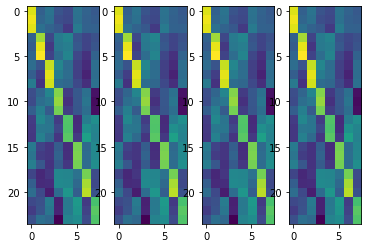

In [53]:
#test single step evaluation by hand
myRNN=RNNModel(4,16,1,8)
myRNN.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(0,4999,"DL")))

O,H=myRNN(signals)
subplot(1,4,1)
imshow(O.data)
os=[]
for i in range(signals.shape[0]):
    h0=myRNN.getEmptyHiddenState()
    for j in range(signals[i].shape[1]):
        I=torch.tensor([[list(signals[i][j])]])
        O,h0=myRNN.singleStep(I,h0)
    os.append(O.data[0].tolist())
subplot(1,4,2)
imshow(os)

subplot(1,4,3)
imshow(myRNN.forwardSingleStep(signals).data)
subplot(1,4,4)
imshow(myRNN.forwardSingelStepWithNoise(signals,[1],[2],0.1).data)

In [6]:
import core
from collections import defaultdict
R=numpy.random.randint(10, size=3000)
symX = core.symbolize(R,2)
print(core.symbolic_transfer_entropy(core.symbolize([1,1,0,0,1,1,0,0],2),core.symbolize([0,1,0,1,0,1,0,1],2)))
print(core.symbolic_transfer_entropy(core.symbolize([1,1,0,0,1,1,0,0],2),core.symbolize([0,1,1,0,0,1,1,0],2)))


0.0
0.4591479170272448


In [5]:
def getPxtpxtytMatrix(x,y):
    ux=unique(x)
    dux=dict()
    for i,u in enumerate(ux):
        dux[u]=i

    uy=unique(y)
    duy=dict()
    for i,u in enumerate(uy):
        duy[u]=i

    M=numpy.zeros((len(ux),len(ux),len(uy)))
    S=0.0
    for t in range(0,len(x)-1):
        M[dux[x[t+1]]][dux[x[t]]][duy[y[t]]]+=1.0
        S+=1.0
    return M/S

def getPxtpxtMatrix(x):
    ux=unique(x)
    dux=dict()
    for i,u in enumerate(ux):
        dux[u]=i
        
    M=numpy.zeros((len(ux),len(ux)))
    S=0.0
    for t in range(0,len(x)-1):
        M[dux[x[t+1]]][dux[x[t]]]+=1.0
        S+=1.0
    return M/S

def getPxtytMatrix(x,y):
    ux=unique(x)
    dux=dict()
    for i,u in enumerate(ux):
        dux[u]=i

    uy=unique(y)
    duy=dict()
    for i,u in enumerate(uy):
        duy[u]=i
    M=numpy.zeros((len(ux),len(uy)))
    S=0.0
    for t in range(0,len(x)):
        M[dux[x[t]]][duy[y[t]]]+=1.0
        S+=1.0
    return M/S

def getPx(x):
    ux=unique(x)
    dux=dict()
    for i,u in enumerate(ux):
        dux[u]=i
    M=numpy.zeros((len(ux)))
    S=0.0
    for i in x:
        M[dux[i]]+=1.0
        S+=1.0
    return M/S
    
def TE(x,y):
    H=0.0
    #print(x,y)
    #print(median(x),median(y))
    #X=list(((x>median(x))*1.0).astype(int))
    #Y=list(((y>median(y))*1.0).astype(int))
    #print(X,Y)
    X=x
    Y=y
    Pxyz=getPxtpxtytMatrix(Y,X)
    Px=getPx(Y) #Y
    Pxy=getPxtytMatrix(Y,X)
    Pxtx=getPxtpxtMatrix(Y)
    ux=unique(x)
    uy=unique(y)
    #print(Pxyz.shape,Px.shape,Pxy.shape,Pxtx.shape)
    for i in range(len(uy)):
        for j in range(len(uy)):
            for k in range(len(ux)):
                if Px[j]>0.0 and Pxtx[i][j]>0.0 and Pxy[i][k]>0.0 and Pxyz[i][j][k]>0.0:
                    H+=Pxyz[i][j][k] * log2((Pxyz[i][j][k]*Px[j])/(Pxy[j][k]*Pxtx[i][j]))
    return H

TE([0,1,2,3,18],[0,1,1,2,19])

0.25

In [7]:
import itertools 
  
def findsubsets(s, n): 
    return list(itertools.combinations(s, n)) 

def computeTEmatrix(H,fromSize=1,upToSize=2,subsample=-1):
    print(H.shape)
    HB=[]
    for i in range(H.shape[0]):
        HB.append((1<<i)*(H[i]>numpy.median(H[i])))
    nodePS=[]
    nodeSet=list(range(H.shape[0]))
    for i in range(fromSize,upToSize):
        nodePS=nodePS+findsubsets(nodeSet,i)
    allJointSets=list()
    for n in nodePS:
        k=tuple(n)
        V=numpy.zeros((H.shape[1]))
        for e in n:
            V+=HB[e]
        allJointSets.append(list(V.astype(int)))
    singlePS=[]
    for i in range(H.shape[0]):
        singlePS.append([i])
    M=numpy.zeros((len(nodePS),len(singlePS)))
    if subsample==-1:
        for a in range(len(nodePS)):
            for b in range(len(singlePS)):
                if a!=b:
                    te=TE(allJointSets[a],allJointSets[b])
                    M[a][b]=te
    else:
        for i in range(subsample):
            a=numpy.random.randint(len(nodePS))
            b=numpy.random.randint(len(singlePS))
            while a==b or M[a][b]>0.0:
                a=numpy.random.randint(len(nodePS))
                b=numpy.random.randint(len(singlePS))
            te=TE(allJointSets[a],allJointSets[b])
            M[a][b]=te
    return M,nodePS,singlePS

M,N,S=computeTEmatrix(H.detach().numpy().reshape((96,16)).transpose(),fromSize=1,upToSize=4,subsample=-1)
imshow(M)
#print(N)

ValueError: cannot reshape array of size 64 into shape (96,16)

In [119]:
collectorT=dict()
collectorW=dict()
timepoint=4999
TM=[]
hiddenSize=16
for kind in ["DL","EVO"]:
    if kind=="DL":
        timepoint=4999
    else:
        timepoint=2000
        
    for i in range(1):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timepoint,kind)))
        O,H=net(signals)
        T,nodePS,singlePS=computeTEmatrix(H.detach().numpy().reshape((96,16)).transpose(),
                                 fromSize=1,upToSize=5,subsample=-1)
        
        collectorT["{0}_{1}".format(kind,i)]=T
        basePerformance=float((1.0*(torch.max(labels,1).indices==torch.max(O,1).indices)).sum())
        allWeights=net.state_dict()
        originalWeightMatrix=allWeights["rnn.weight_hh_l0"].clone()
        perfMatrix=numpy.zeros((len(nodePS),len(singlePS)))
        print(len(nodePS))
        tic()
        X,Y=numpy.nonzero(T)
        print(len(X))
        for j in range(len(X)):
            x=X[j]
            y=Y[j]
            P=[]
            for w in linspace(0.0,4.0,21):
                O=myRNN.forwardSingelStepWithNoise(signals,nodePS[x],singlePS[y],w)
                myRNN.weight_hh_10=originalWeightMatrix.clode()
                perf=float((1.0*(torch.max(labels,1).indices==torch.max(O,1).indices)).sum())/basePerformance
                P.append(perf)
            perfMatrix[x][y]=mean(P)
        print(toc())
        collectorW["{0}_{1}".format(kind,i)]=perfMatrix

(16, 96)
2516
100
53.80877375602722
(16, 96)
2516
100
52.82914996147156


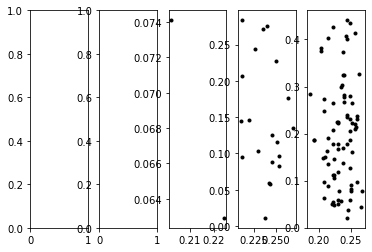

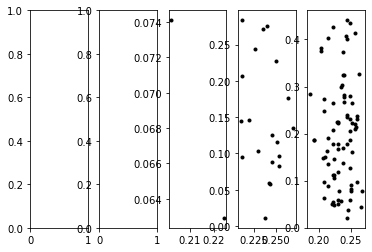

In [135]:
for kind in ["DL","EVO"]:
    for i in range(1):
        W=collectorW["DL_99"]
        T=collectorT["DL_0"]
        X,Y=numpy.nonzero(T)
        subCor=dict()
        for j in range(len(X)):
            l=len(nodePS[X[j]])
            if l not in subCor:
                subCor[l]=[[],[]]
            subCor[l][0].append(W[X[j]][Y[j]])
            subCor[l][1].append(T[X[j]][Y[j]])
        figure()
        for k in range(5):
            subplot(1,5,k+1)
            if k in subCor:
                plot(subCor[k][0],subCor[k][1],'.k')

In [8]:
def WforSubset(model,originalMatrix,signals,labels,setSource,setTarget,steps=21):
    P=[]
    for w in linspace(0.0,4.0,steps):
        O=model.forwardSingelStepWithNoise(signals,setSource,setTarget,w)
        myRNN.weight_hh_10=originalMatrix.clone()
        perf=float((1.0*(torch.max(labels,1).indices==torch.max(O,1).indices)).sum())
        P.append(perf)
    return mean(P)

WforSubset(myRNN,originalWeightMatrix,signals,labels,[1,2,3],[4],steps=21)

NameError: name 'originalWeightMatrix' is not defined

In [199]:
net=RNNModel(4,hiddenSize,1,8)
net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(0,2000,"EVO")))
allWeights=net.state_dict()
originalWeightMatrix=allWeights["rnn.weight_hh_l0"].clone()
basePerformance=WforSubset(myRNN,originalWeightMatrix,signals,labels,[],[],steps=21)
print(basePerformance)

O,H=net(signals)
H=H.detach().numpy().reshape((96,16)).transpose()
HB=[]
for i in range(H.shape[0]):
    HB.append((1<<i)*(H[i]>numpy.median(H[i])))

currentSet=list(range(hiddenSize))
allTE=dict()
allW=dict()
while len(currentSet)>1:
    allTE[len(currentSet)]=[]
    allW[len(currentSet)]=[]
    best=dict()
    for node in currentSet:
        nextSet=list(currentSet)
        nextSet.remove(node)
        
        V=numpy.zeros((H.shape[1]))
        for subSetNode in nextSet:
            V+=HB[subSetNode]
        for targetNode in range(H.shape[0]):
            te=TE(V,HB[targetNode])
            if te not in best:
                best[te]=[]
            best[te].append(nextSet)
            allTE[len(currentSet)].append(te)
            
            w=WforSubset(myRNN,originalWeightMatrix,signals,labels,nextSet,[targetNode],steps=3)
            allW[len(currentSet)].append(w/basePerformance)
            #print(te,w)
    bestScore=max(best.keys())
    print(bestScore,best[bestScore])
    currentSet=best[bestScore][0]

7.0
0.4167179773925649 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
0.42927213610774806 [[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
0.4412740061924666 [[1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
0.47848806253051157 [[1, 2, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15]]
0.47848806253051157 [[1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15], [1, 2, 4, 6, 8, 9, 10, 11, 13, 14, 15], [1, 2, 4, 6, 7, 9, 10, 11, 13, 14, 15]]
0.49170919030882554 [[1, 2, 6, 7, 9, 10, 11, 13, 14, 15]]
0.493737033234535 [[1, 2, 6, 7, 9, 11, 13, 14, 15]]
0.6200528227082195 [[1, 2, 6, 7, 9, 13, 14, 15]]
0.6200528227082195 [[1, 2, 6, 9, 13, 14, 15]]
0.6028167182806898 [[1, 2, 6, 9, 13, 15]]
0.5846438704503156 [[1, 2, 6, 9, 15]]
0.5433259011818361 [[2, 6, 9, 15]]
0.4010645898161344 [[2, 6, 9]]
0.30721351620756054 [[2, 6]]
0.1686501644641249 [[6]]


KeyError: 2

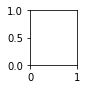

In [201]:
from scipy import stats
#print(stats.spearmanr(gaX,gaY))
#print(stats.spearmanr(bpX,bpY))

figure(figsize=[16,1])
X=[]
Y=[]
for i in range(2,17):
    subplot(1,16,i-1)
    plot(allW[i],allTE[i],'.k')
    src=stats.spearmanr(allW[i],allTE[i])
    print(i,src)
    X.append(i)
    Y.append(src[0])
#tight_layout()
figure()
plot(X,Y)

In [321]:
timepoint=4999
TM=[]
hiddenSize=16
for kind in ["DL","EVO"]:
    if kind=="DL":
        timepoint=4999
    else:
        timepoint=2000
        
    for orgID in range(50):
        print("kind",kind,"orgID",orgID)
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(orgID,timepoint,kind)))
        allWeights=net.state_dict()
        originalWeightMatrix=allWeights["rnn.weight_hh_l0"].clone()
        basePerformance=WforSubset(myRNN,originalWeightMatrix,signals,labels,[],[],steps=21)
        print(basePerformance)

        O,H=net(signals)
        H=H.detach().numpy().reshape((96,16)).transpose()
        HB=[]
        for i in range(H.shape[0]):
            HB.append((1<<i)*(H[i]>numpy.median(H[i])))

        currentSet=list(range(hiddenSize))
        allTE=dict()
        allW=dict()
        for i in range(1,16):
            allTE[i]=[]
            allW[i]=[]
            for n in range(50):
                nextSet=list(numpy.random.choice(list(range(H.shape[0])),i,replace=False))
                targetNode=numpy.random.choice(list(range(H.shape[0])))
                while targetNode in nextSet:
                    targetNode=numpy.random.choice(list(range(H.shape[0])))
                V=numpy.zeros((H.shape[1]))
                for subSetNode in nextSet:
                    V+=HB[subSetNode]
                te=TE(V,HB[targetNode])
                allTE[i].append(te)

                w=WforSubset(myRNN,originalWeightMatrix,signals,labels,nextSet,[targetNode],steps=11)
                allW[i].append(w/basePerformance)
        #print(nextSet,targetNode,te,w)
        pickle.dump( allW, open( "TE_W_long/data_W_{0}_{1}.p".format(kind,orgID), "wb" ) )
        pickle.dump( allTE, open( "TE_W_long/data_TE_{0}_{1}.p".format(kind,orgID), "wb" ) )

kind DL orgID 0
6.0
kind DL orgID 1
6.0
kind DL orgID 2
6.0
kind DL orgID 3
6.0
kind DL orgID 4
6.0
kind DL orgID 5
6.0
kind DL orgID 6
6.0
kind DL orgID 7
6.0
kind DL orgID 8
6.0
kind DL orgID 9
6.0
kind DL orgID 10
6.0
kind DL orgID 11
6.0
kind DL orgID 12
6.0
kind DL orgID 13
6.0
kind DL orgID 14
6.0
kind DL orgID 15
6.0
kind DL orgID 16
6.0
kind DL orgID 17
6.0
kind DL orgID 18
6.0
kind DL orgID 19
6.0
kind DL orgID 20
6.0
kind DL orgID 21
6.0
kind DL orgID 22
6.0
kind DL orgID 23
6.0
kind DL orgID 24
6.0
kind DL orgID 25
6.0
kind DL orgID 26
6.0
kind DL orgID 27
6.0
kind DL orgID 28
6.0
kind DL orgID 29
6.0
kind DL orgID 30
6.0
kind DL orgID 31
6.0
kind DL orgID 32
6.0
kind DL orgID 33
6.0
kind DL orgID 34
6.0
kind DL orgID 35
6.0
kind DL orgID 36
6.0
kind DL orgID 37
6.0
kind DL orgID 38
6.0
kind DL orgID 39
6.0
kind DL orgID 40
6.0
kind DL orgID 41
6.0
kind DL orgID 42
6.0
kind DL orgID 43
6.0
kind DL orgID 44
6.0
kind DL orgID 45
6.0
kind DL orgID 46
6.0
kind DL orgID 47
6.0
ki

NameError: name 'allW' is not defined

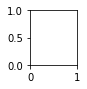

In [9]:
from scipy import stats
#print(stats.spearmanr(gaX,gaY))
#print(stats.spearmanr(bpX,bpY))

figure(figsize=[16,1])
X=[]
Y=[]
for i in range(1,16):
    subplot(1,16,i)
    plot(allW[i],allTE[i],'.k')
    src=stats.spearmanr(allW[i],allTE[i])
    print(i,src)
    X.append(i)
    Y.append(src[0])
#tight_layout()
figure()
plot(X,Y)

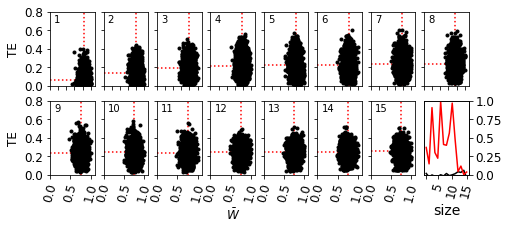

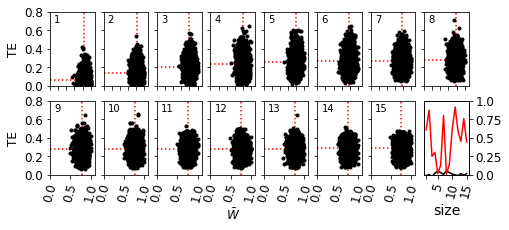

In [10]:
collector=dict()
for kind in ["DL","EVO"]:
    W=dict()
    T=dict()
    for i in range(1,16):
        W[i]=[]
        T[i]=[]
    for orgID in range(50):
        allW=pickle.load(open( "TE_W_long/data_W_{0}_{1}.p".format(kind,orgID), "rb" ) )
        allTE=pickle.load( open( "TE_W_long/data_TE_{0}_{1}.p".format(kind,orgID), "rb" ) )
        w=[]
        for i in range(1,16):
            w=w+allW[i]
        for i in range(1,16):
            W[i]+=list(numpy.array(allW[i])/max(w))
            T[i]+=allTE[i]
    X=[]
    C=[]
    P=[]
    MT=[]
    MW=[]
    MTE=[]
    MWE=[]
    figure(figsize=[7.5,3])
    for i in range(1,16):
        subplot(2,8,i)
        plot([0,1],[mean(T[i]),mean(T[i])],':r')
        plot([mean(W[i]),mean(W[i])],[0,1],':r')
        plot(W[i],T[i],'.k')
        src=stats.spearmanr(W[i],T[i])
        C.append(src[0])
        P.append(src[1])
        MT.append(mean(T[i]))
        MW.append(mean(W[i]))
        MWE.append(std(W[i])/sqrt(len(W[i])))
        MTE.append(std(T[i])/sqrt(len(T[i])))
        X.append(i)
        ylim(0,0.8)
        xlim(0,1.1)
        text(0.1,0.68,str(i))
        if i in [1,9]:
            yticks([0,0.2,0.4,0.6,0.8],['0.0','0.2','0.4','0.6','0.8'],fontsize=12)
            ylabel("TE",fontsize=12)
        else:
            yticks([0,0.2,0.4,0.6,0.8],['','','','','',''],fontsize=12)
        if i in [9,10,11,12,13,14,15]:
            xticks([0,0.5,1.0],['0.0','0.5','1.0'],fontsize=12,rotation=75)
            if i==12:
                xlabel(r"$\bar{W}$",fontsize=12)
        else:
            xticks([0,0.2,0.4,0.6,0.8,1.0],['','','','','',''],fontsize=12)
    subplot(2,8,16)
    plot()
    yticks([],[])
    xticks([1,5,10,15],['','5','10','15'],fontsize=12,rotation=75)
    xlabel("size",fontsize=14)
    twinx()
    plot(X,C,'k')
    plot(X,P,'r' )
    yticks([0,0.25,0.5,0.75,1.0],['0.0','0.25','0.5','0.75','1.0'],fontsize=12)
    #plot(X,MW,'b')
    #plot(X,MT,'g')
    ylim(0,1)
    collector["{0} MW".format(kind)]=numpy.array(MW)
    collector["{0} MT".format(kind)]=numpy.array(MT)
    collector["{0} MWE".format(kind)]=numpy.array(MWE)
    collector["{0} MTE".format(kind)]=numpy.array(MTE)
    savefig("largerSets_{0}.pdf".format(kind))

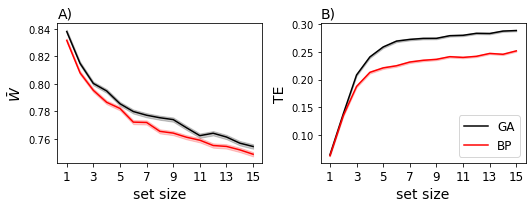

In [33]:
figure(figsize=[7.5,3])
subplot(1,2,1)
plot(X,collector["EVO MW"],'k')
fill_between(X,collector["EVO MW"]+collector["EVO MWE"],collector["EVO MW"]-collector["EVO MWE"],color='k',alpha=0.2)
plot(X,collector["DL MW"],'r')
fill_between(X,collector["DL MW"]+collector["DL MWE"],collector["DL MW"]-collector["DL MWE"],color='r',alpha=0.2)
xticks([1,3,5,7,9,11,13,15],['1','3','5','7','9','11','13','15'],fontsize=12)
xlabel("set size",fontsize=14)
ylabel(r"$\bar{W}$",fontsize=14)
title("A)",loc='left',fontsize=14)
#text(14,0.727,"A)",fontsize=14)
subplot(1,2,2)

plot(X,collector["EVO MT"],'k',label="GA")
fill_between(X,collector["EVO MT"]+collector["EVO MTE"],collector["EVO MT"]-collector["EVO MTE"],color='k',alpha=0.2)
plot(X,collector["DL MT"],'r',label="BP")
fill_between(X,collector["DL MT"]+collector["DL MTE"],collector["DL MT"]-collector["DL MTE"],color='r',alpha=0.2)
xticks([1,3,5,7,9,11,13,15],['1','3','5','7','9','11','13','15'],fontsize=12)
xlabel("set size",fontsize=14)
ylabel("TE",fontsize=14)
title("B)",loc='left',fontsize=14)
legend(loc=4,fontsize=12)
tight_layout()
savefig("W_and_T_over_set.pdf")

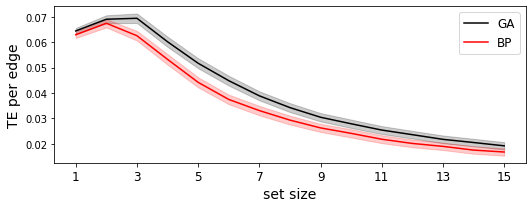

In [24]:
figure(figsize=[7.5,3])
plot(X,collector["EVO MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]),'k',label="GA")
fill_between(X,(collector["EVO MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))+collector["EVO MTE"],(collector["EVO MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))-collector["EVO MTE"],color='k',alpha=0.2)
plot(X,collector["DL MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]),'r',label="BP")
fill_between(X,(collector["DL MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))+collector["DL MTE"],(collector["DL MT"]/numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))-collector["DL MTE"],color='r',alpha=0.2)
xticks([1,3,5,7,9,11,13,15],['1','3','5','7','9','11','13','15'],fontsize=12)
xlabel("set size",fontsize=14)
ylabel("TE per edge",fontsize=14)
#title("B)",loc='left',fontsize=14)
legend(loc=1,fontsize=12)
tight_layout()
savefig("perEdgeTE.pdf")

In [12]:
collector["EVO MT"]

array([0.06442054, 0.13804224, 0.2082093 , 0.2406139 , 0.25852005,
       0.2690874 , 0.27215027, 0.27395337, 0.27407619, 0.2788425 ,
       0.27954906, 0.28313295, 0.28277654, 0.28716344, 0.28812245])

In [109]:
len(X)

995

In [116]:
M.max()

0.5521836632677267

In [169]:
L=list(numpy.random.randint(0,2,(100)))
print(TE(L[1:],L[:-1]))
print(TE(L[:-1],L[1:]))

0.9960773212125162
0.009667870665386694


In [26]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

mean_confidence_interval(numpy.random.random((100)))

0.05750430966809448

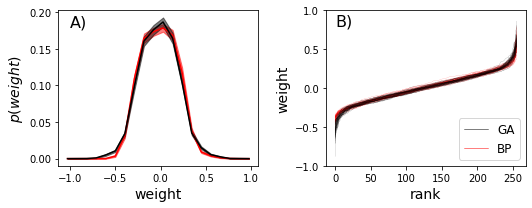

In [43]:
figure(figsize=[7.5,3])
subplot(1,2,1)
hiddenSize=16
cols={"DL":"r","EVO":"k"}
labels={"DL":"BP","EVO":"GA"}
rawdata=dict()
for kind in ["DL","EVO"]:
    if kind=="DL":
        timePoint=4999
    else:
        timePoint=2000
    H=[]
    R=[]
    for i in range(50):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
        Y=net.rnn.weight_hh_l0.data.flatten().tolist()
        #plot(sort(Y),cols[kind],linewidth=0.1)
        H0,H1=histogram(Y,linspace(-1,1,21))
        H.append(numpy.array(H0)/256)
        R=R+Y
    rawdata[kind]=R
#    ylim(-1,1)\
    M=numpy.array(H).mean(0)
    #E=numpy.array(H).var(0)#std(0)/sqrt(50)
    E=[]
    for col in numpy.array(H).transpose():
        E.append(mean_confidence_interval(col))
    E=numpy.array(E)
    fill_between(linspace(-1-0.025,1-0.025,20),M+E,M-E,color=cols[kind],alpha=0.5)
    plot(linspace(-1-0.025,1-0.025,20),M,color=cols[kind])

text(-1.0,0.18,"A)",fontsize=16)
#savefig("distribution.pdf")
xlabel("weight",fontsize=14)
ylabel(r"$p(weight)$",fontsize=14)
subplot(1,2,2)
hiddenSize=16
cols={"DL":"r","EVO":"k"}
for kind in ["DL","EVO"]:
    if kind=="DL":
        timePoint=4999
    else:
        timePoint=2000
    H=[]
    for i in range(50):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
        Y=net.rnn.weight_hh_l0.data.flatten().tolist()
        plot(sort(Y),"-"+cols[kind],linewidth=0.1,markersize=0.2)
        H=H+Y
    ylim(-1,1)
    #hist(H,linspace(-1,1,101),color=cols[kind])
xlabel("rank",fontsize=14)
ylabel("weight",fontsize=14)
text(0,0.8,"B)",fontsize=16)

legend([Line2D([0], [0], color='k', linewidth=0.5, linestyle='-'),Line2D([0], [0], color='r', linewidth=0.5, linestyle='-')],["GA","BP"],loc=4,fontsize=12)
tight_layout()
savefig("weightsAreTheSame.pdf")

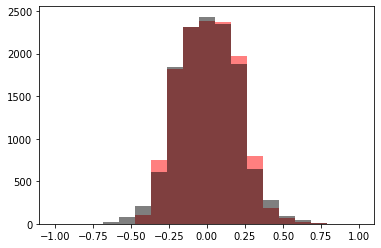

In [40]:
hiddenSize=16
cols={"DL":"r","EVO":"k"}
for kind in ["DL","EVO"]:
    if kind=="DL":
        timePoint=4999
    else:
        timePoint=2000
    H=[]
    for i in range(50):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
        Y=net.rnn.weight_hh_l0.data.flatten().tolist()
        #plot(sort(Y),cols[kind],linewidth=0.1)
        H=H+Y
#    ylim(-1,1)
    hist(H,linspace(-1,1,20),color=cols[kind],alpha=0.5)
savefig("distribution.pdf")

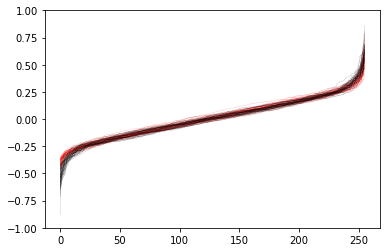

In [35]:
hiddenSize=16
cols={"DL":"r","EVO":"k"}
for kind in ["DL","EVO"]:
    if kind=="DL":
        timePoint=4999
    else:
        timePoint=2000
    H=[]
    for i in range(50):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
        Y=net.rnn.weight_hh_l0.data.flatten().tolist()
        plot(sort(Y),cols[kind],linewidth=0.1)
        H=H+Y
    ylim(-1,1)
    #hist(H,linspace(-1,1,101),color=cols[kind])
savefig("sorted.pdf")

In [19]:
tic()
pop=[]
popsize=100
hiddenSize=16
for p in range(popsize):
    net=RNNModel(4,hiddenSize,1,8,startZero=False)
    net.eval()
    pop.append(net)
    
order=list(range(5))

generations=2000
histories=[]
Wmeans=[]
Wmax=[]
for g in range(generations):
    numpy.random.shuffle(order)
    W=[]
    E=[]
    noise=torch.normal(0.0,0.05,signals.shape)

    for p in range(popsize):
        # the below line returns outputs and history, history are the hidden states of the RNN layer
        outputs,history = pop[p](signals)#+noise)
        
        e=float((1.0*(torch.max(labels,1).indices==torch.max(outputs,1).indices)).sum())
        W.append(e)
        l=1.0-(((outputs.data-labels.data)**2.0).sum()/(outputs.shape[0]*outputs.shape[1]))
        E.append(l)
    newPop=[]
    Wmeans.append(mean(W))
    Wmax.append(max(W))
    #E=list(numpy.array(W)*(1.0/numpy.array(E)))
    E=list(1.5**(numpy.array(W)*numpy.array(E)))
    maxW=max(E)
    for p in range(popsize):
        who=numpy.random.randint(popsize)
        while (numpy.random.random()*maxW)>E[who]:
            who=numpy.random.randint(popsize)
            
        if p<1:
            who=E.index(max(E))
            net=RNNModel(4,hiddenSize,1,8)
            net.inheritPointwise(pop[who],my=0.0)
            bestLastNetwork=pop[who]
        else:
            net=RNNModel(4,hiddenSize,1,8)
            net.inheritPointwise(pop[who],my=0.001)            
        newPop.append(net)
    pop=newPop
    if (g%100)==0:
        print(g,max(W),mean(W),max(E),mean(E))#,E)
    if (g%10)==0:
        histories.append(numpy.array(history.data))
print("time",toc())

0 7.0 3.26 11.127887770449705 3.3444704245402757
100 11.0 10.46 47.81582308464509 39.96751271647461
200 13.0 11.98 97.40209010150507 73.04444564052115
300 14.0 12.96 144.0946002707871 108.44201566607937
400 14.0 12.93 150.17586906934116 112.40317366007143
500 15.0 13.95 220.62198188036567 164.48986646061854
600 17.0 16.04 462.50730830265684 354.05357743894143
700 17.0 16.2 482.21992841276676 375.03263123256517
800 17.0 16.28 499.02844533321934 397.56095266385734
900 18.0 16.86 746.5440902921591 505.36087417792265
1000 19.0 18.36 1100.6602915204094 917.358464931779
1100 19.0 18.28 1128.549323162904 921.0572812980776
1200 20.0 19.03 1668.5947277889109 1279.4852911038804
1300 21.0 20.0 2442.165988279315 1855.0083788082147
1400 21.0 19.97 2471.190308804845 1831.9272058811182
1500 22.0 21.16 3669.251395647339 2836.0579778684705
1600 23.0 22.5 5445.588904968226 4661.340279100542
1700 24.0 23.64 8011.848832610514 7191.70370126309
1800 24.0 23.49 8202.09395135275 7013.37202268578
1900 24.0 23.

(2000, 16, 4)


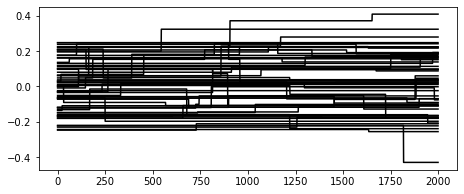

In [20]:
figure(figsize=[7.5,3])
weights=numpy.array(pop[0].weightsLOD)
print(weights.shape)
p=plot(weights.reshape((2000,16*4)),'k')
#savefig("weights_LOD.pdf")
pickle.dump(weights,open("LODWeightsNoneZero.p","wb"))

4.740000009536743


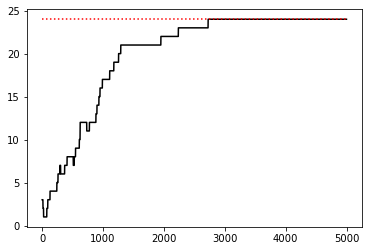

In [40]:
hiddenWidth=16
myRNN=RNNModel(4,hiddenWidth,1,8,startZero=False)
optimizer = optim.SGD(myRNN.parameters(), lr=0.003, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

episodes=5000
order=list(range(len(signals)))


E=[]
L=[]
histories=[]
tic()

weights=[]
for episode in range(episodes):
    
    numpy.random.shuffle(order)
        # Forward propagation
        
    optimizer.zero_grad()

    noise=torch.normal(0.0,0.1,signals.shape)
    outputs,history = myRNN(signals[order])
    histories.append(numpy.array(history.data))
    loss = error(outputs.double(), labels[order])
    L.append(float(loss))
    e=float((1.0*(torch.max(labels[order],1).indices==torch.max(outputs,1).indices)).sum())
        # Calculating gradients       
    E.append(e)
    loss.backward()
    optimizer.step()
    weights.append(myRNN.rnn.weight_ih_l0.data.tolist())
plot(E,'k')
plot([0,len(E)],[24,24],':r')
print(toc())

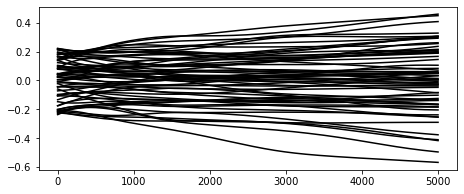

In [42]:
figure(figsize=[7.5,3])
weights=numpy.array(weights)
p=plot(weights.reshape((5000,16*4)),'k')
#savefig("weights_BP.pdf")
pickle.dump(weights,open("BPWeights.p","wb"))

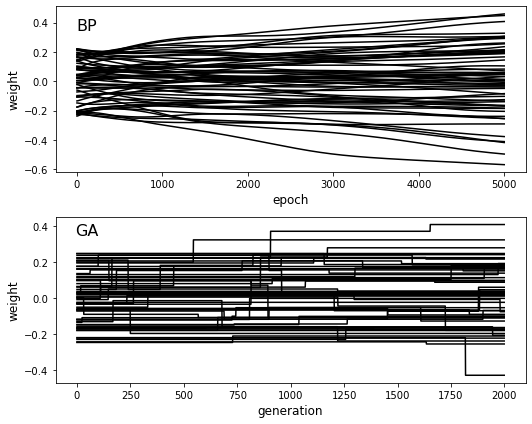

In [21]:
figure(figsize=[7.5,6])
weights=pickle.load(open("BPWeights.p","rb") )
subplot(2,1,1)
p=plot(weights.reshape((5000,16*4)),'k')
text(-10,0.35,"BP",fontsize=16)
ylabel("weight",fontsize=12)
xlabel("epoch",fontsize=12)

subplot(2,1,2)
weights=pickle.load(open("LODWeightsNoneZero.p","rb") )
p=plot(weights.reshape((2000,16*4)),'k')
text(-10,0.35,"GA",fontsize=16)
ylabel("weight",fontsize=12)
xlabel("generation",fontsize=12)
tight_layout()
savefig("weightIllustration.pdf")

In [57]:
H0,H1=histogram(Y)

In [58]:
H0

array([ 8,  8, 38, 42, 47, 53, 28, 16, 13,  3])

In [63]:
E

array([0.00000e+00, 0.00000e+00, 1.96000e-02, 0.00000e+00, 0.00000e+00,
       3.84000e-02, 1.96000e-02, 2.22400e-01, 2.50000e-01, 9.79600e-01,
       7.36400e-01, 1.39040e+00, 3.72160e+00, 4.76640e+00, 7.07560e+00,
       1.62976e+01, 1.52004e+01, 1.79924e+01, 1.90544e+01, 1.58336e+01,
       1.45904e+01, 2.18676e+01, 1.90576e+01, 1.93284e+01, 1.32256e+01,
       5.88840e+00, 5.25000e+00, 2.19360e+00, 2.19560e+00, 1.20360e+00,
       9.30000e-01, 4.50000e-01, 4.00000e-01, 2.11600e-01, 3.84000e-02,
       1.96000e-02, 1.96000e-02, 1.96000e-02, 0.00000e+00, 0.00000e+00])

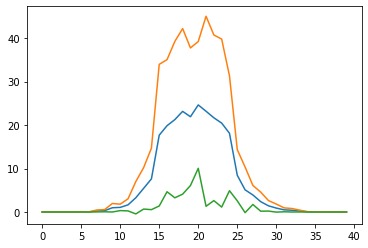

In [70]:
plot(M)
plot(M+E)
plot(M-E)

/Users/arendhintze/miniconda3/envs/pyphi/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


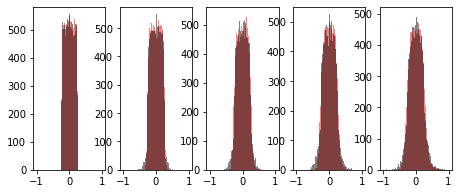

In [22]:
figure(figsize=[7.5,3])
hiddenSize=16
cols={"DL":"r","EVO":"k"}
for t in range(5):
    for kind in ["DL","EVO"]:
        if kind=="DL":
            timePoints=[0,1000,2000,3000,4999]
        else:
            timePoints=[0,500,1000,1500,2000]
        timePoint=timePoints[t]
        H=[]
        for i in range(50):
            net=RNNModel(4,hiddenSize,1,8)
            net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
            Y=net.rnn.weight_hh_l0.data.flatten().tolist()
            #plot(sort(Y),cols[kind],linewidth=0.1)
            H=H+Y
    #    ylim(-1,1)
        subplot(1,5,t+1)
        hist(H,linspace(-1,1,101),color=cols[kind],alpha=0.5)
savefig("distributionsOverTime.pdf")

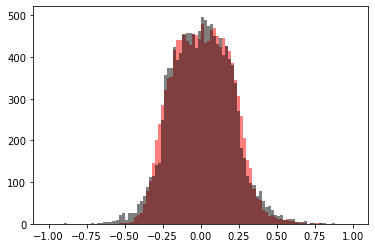

In [ ]:
hiddenSize=16
rawdata=dict()
for kind in ["DL","EVO"]:
    if kind=="DL":
        timePoint=4999
    else:
        timePoint=2000
    H=[]
    R=[]
    for i in range(50):
        net=RNNModel(4,hiddenSize,1,8)
        net.load_state_dict(torch.load("{2}_data/bestModel_{1}_{0}.model".format(i,timePoint,kind)))
        Y=net.rnn.weight_hh_l0.data.flatten().tolist()
        R=R+Y
    rawdata[kind]=R

In [34]:
stats.ks_2samp(rawdata["DL"], rawdata["EVO"])

Ks_2sampResult(statistic=0.018984375, pvalue=0.01983996540890362)

In [33]:
rawdata.keys()

dict_keys(['DL', 'EVO'])

In [41]:
linspace(-1,1,20)

array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])